In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics

Chain Length: 10 mean: 3595.99 +- 152.97 absolute_min: 3439.74
Chain Length: 100 mean: 2850.87 +- 107.11 absolute_min: 2765.06
Chain Length: 250 mean: 2787.21 +- 64.88 absolute_min: 2723.0
Chain Length: 500 mean: 2732.76 +- 96.14 absolute_min: 2640.6
Chain Length: 750 mean: 2698.81 +- 72.54 absolute_min: 2607.17
Chain Length: 1000 mean: 2683.67 +- 74.42 absolute_min: 2605.43
Chain Length: 1500 mean: 2673.72 +- 104.82 absolute_min: 2606.27


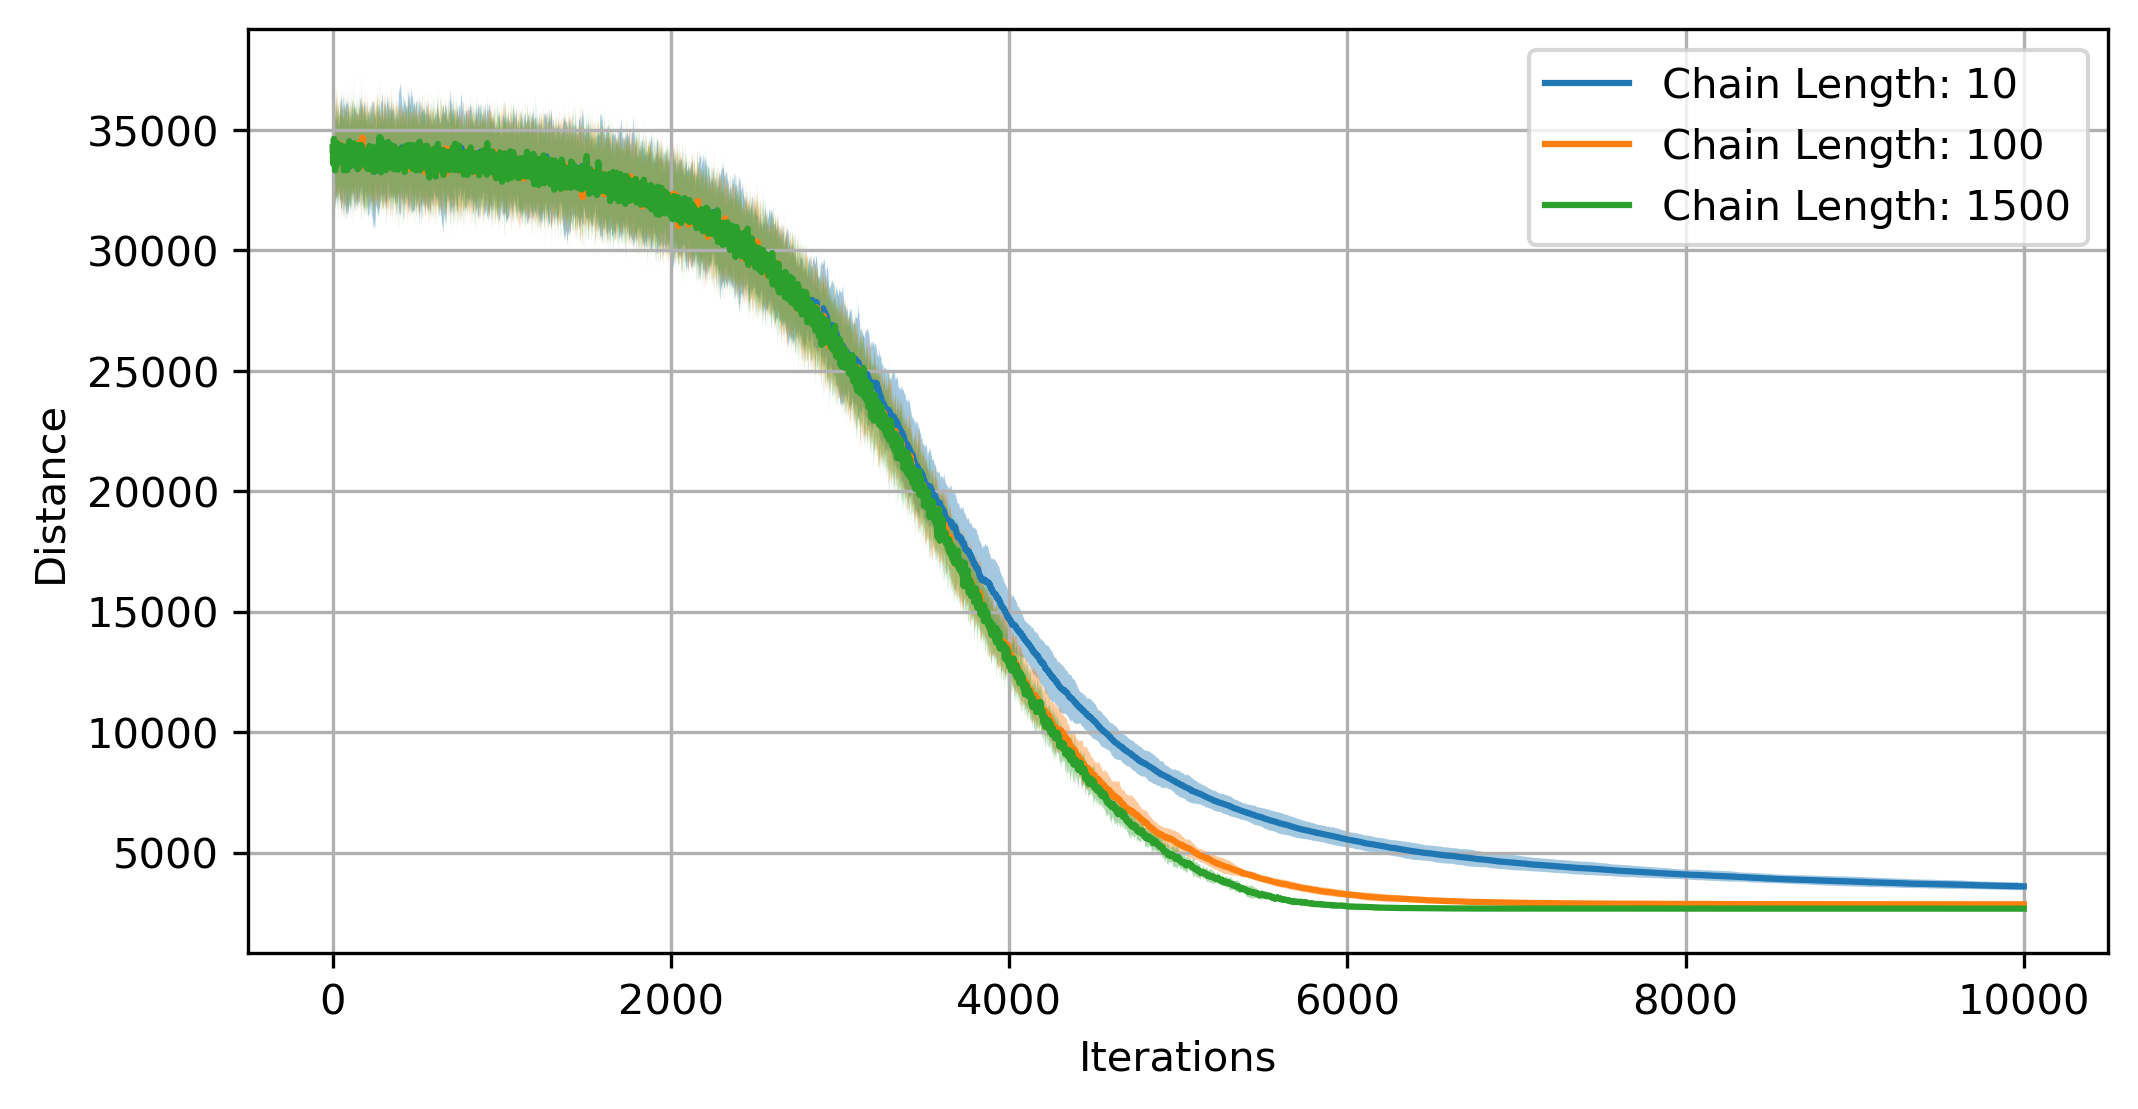

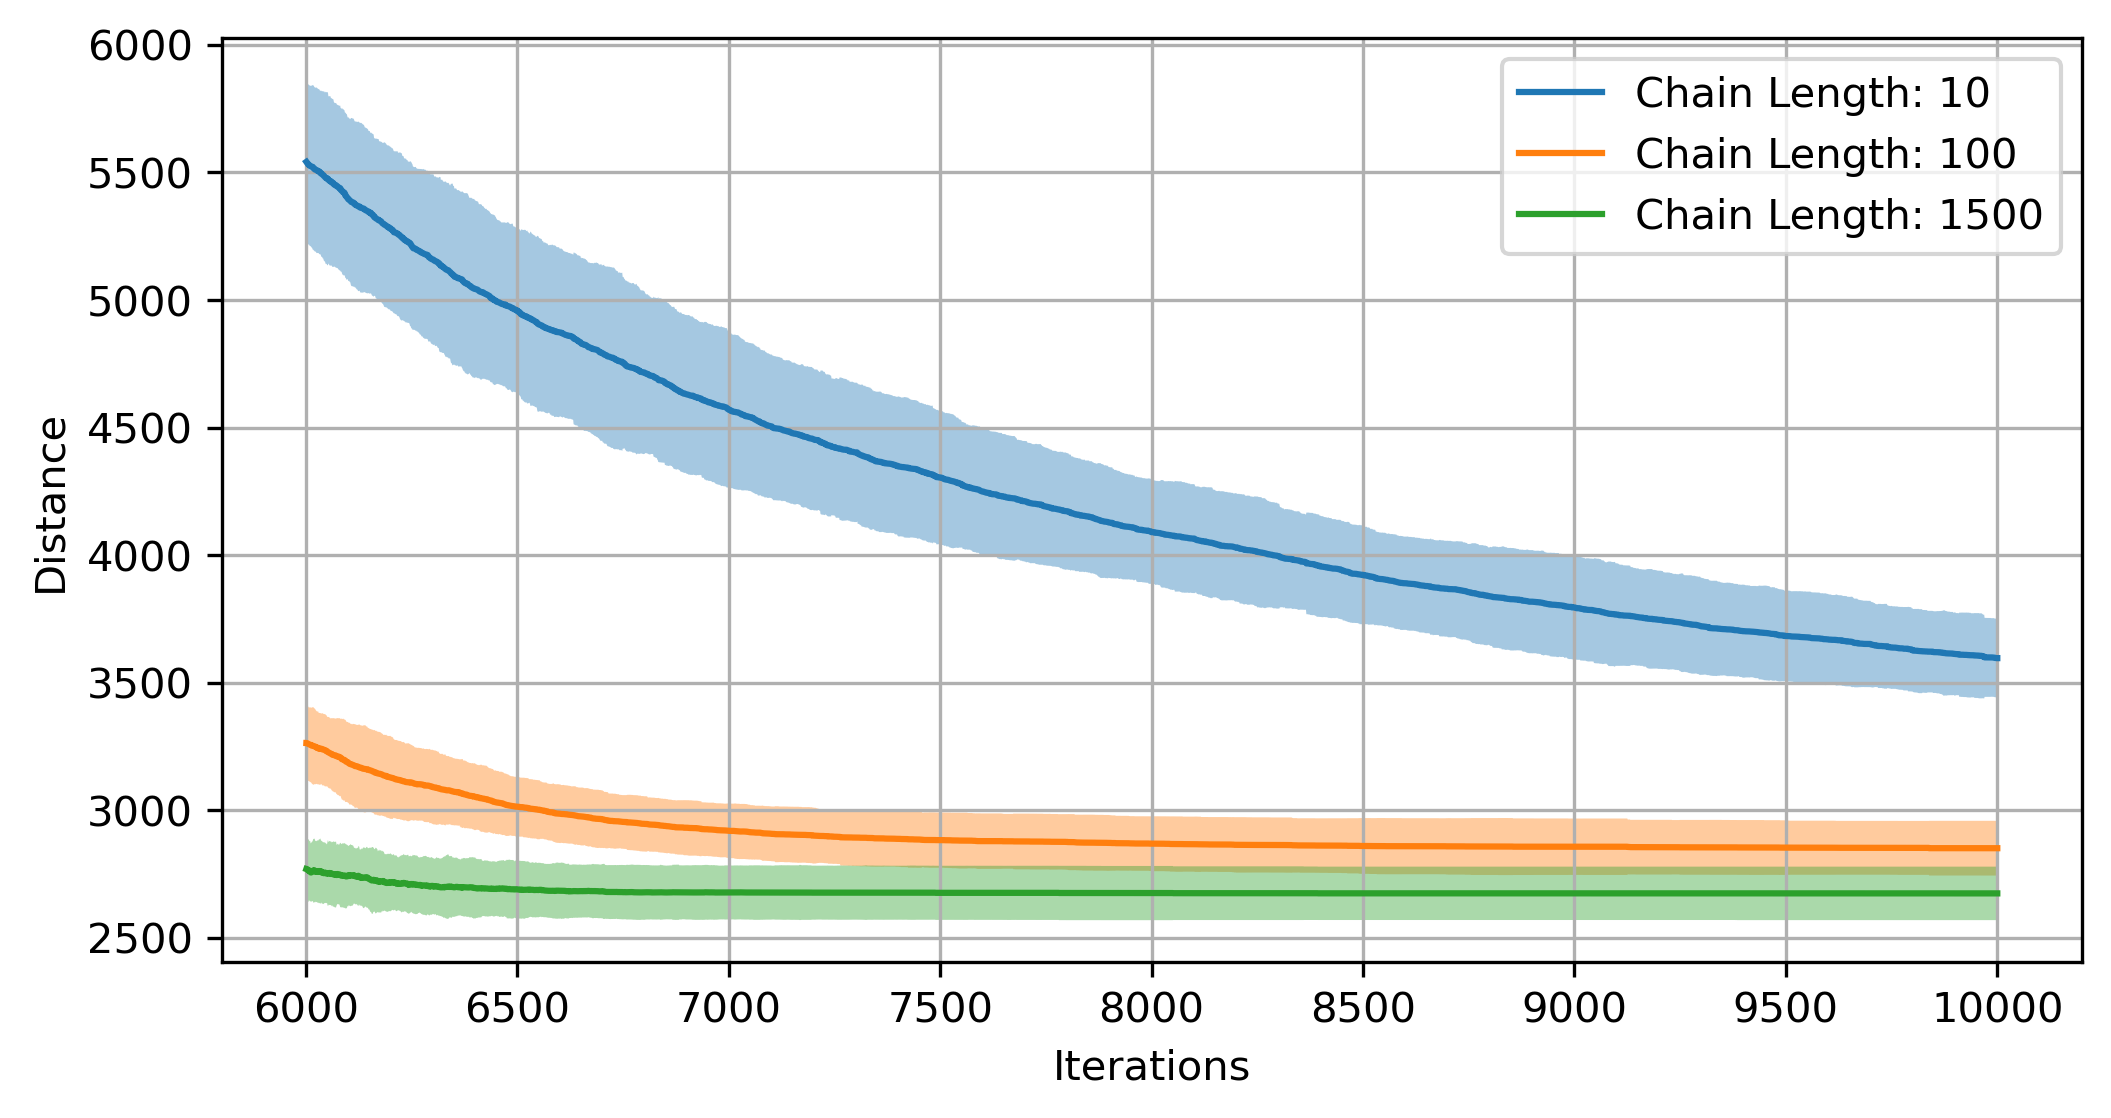

In [89]:
# Helper function to compute mean and CI
def mean_confidence_interval(data, confidence=0.95):
    data = list(data)
    n = len(data)
    if n < 2:
        # Not enough data points for CI
        mean_val = statistics.mean(data) if n > 0 else float('nan')
        return mean_val, mean_val, mean_val
    mean_val = statistics.mean(data)
    stdev = statistics.pstdev(data) if n == len(data) else statistics.stdev(data)
    # For 95% CI using normal approximation
    z = 1.96
    stderr = stdev / math.sqrt(n)
    lower = mean_val - z * stderr
    upper = mean_val + z * stderr
    return mean_val, lower, upper

# Parameters
csv_filename = 'simulation_results_a280_6000_geometric_markov_lengths.csv'
chain_lengths_smaller = [10,100,1500]
chain_lengths = [10,100,250,500,750,1000,1500]
# Initialise absolute minimum
abs_min = 5000

# Read the CSV
df = pd.read_csv(csv_filename)
#print(df)

# Convert 'Distances', 'Temperatures', and 'Iterations' from string to list
#df['Distances'] = df['Distances'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
#df['Temperatures'] = df['Temperatures'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
#df['Iterations'] = df['Iterations'].str.strip("[]").str.split(", ").apply(lambda x: list(map(int, x)))

# Filter for the desired cooling types
#df = df[df['Cooling Type'].isin(cooling_types_of_interest)]

# Group data by cooling type
#cooling_types = df['Cooling Type'].unique()

# Convert 'Distances', 'Temperatures', and 'Iterations' from string to list
df['Distances'] = df['Distances'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
df['Temperatures'] = df['Temperatures'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
df['Iterations'] = df['Iterations'].str.strip("[]").str.split(", ").apply(lambda x: list(map(int, x)))

aggregated = {}
for chain_length in chain_lengths:
    subset = df[df['Markov Length'] == chain_length]
    if len(subset) == 0:
        continue
    
    # Convert all runs distances and temperatures into DataFrames
    dist_df = pd.DataFrame(subset['Distances'].tolist())    # rows = runs, cols = iterations
    temp_df = pd.DataFrame(subset['Temperatures'].tolist())    # rows = runs, cols = iterations
    iter_df = pd.DataFrame(subset['Iterations'].tolist())      # rows = runs, cols = iterations
    n_runs = len(subset)
    
    dist_mean = dist_df.mean(axis=0)
    dist_std = dist_df.std(axis=0)
    dist_lower = dist_mean - 2 * dist_std
    dist_upper = dist_mean + 2 * dist_std
    
    dist_min = dist_df.min().min()
    final_dist_mean = dist_df.iloc[:, -1].mean()
    final_dist_stdev = dist_df.iloc[:, -1].std()
    print('Chain Length:', chain_length,
          'mean:', round(final_dist_mean,2), '+-', round(2 * final_dist_stdev,2),
          'absolute_min:', round(dist_min,2))
    
    if dist_min < abs_min:
        abs_min = dist_min
    
    temp_mean = temp_df.mean(axis=0)
    temp_std = temp_df.std(axis=0)
    
     # Compute average max iterations
    max_iterations_per_run = iter_df.apply(lambda x: x.iloc[-1], axis=1)
    avg_max_iterations = max_iterations_per_run.mean()
    
    if chain_length in chain_lengths_smaller:
        aggregated[chain_length] = {
            'dist_mean': dist_mean,
            'dist_lower': dist_lower,
            'dist_upper': dist_upper,
            'temp': temp_mean,
            'iterations': range(len(dist_mean)),
            'avg_max_iterations': avg_max_iterations,
            'n_runs': n_runs,
            'dist_df': dist_df
        }
    
# Plot Distance vs Iteration with CI
plt.figure(figsize=(8, 4), dpi = 300)
for chain_length, data in aggregated.items():
    it = data['iterations']
    plt.plot(it, data['dist_mean'], label=f'Chain Length: {chain_length}')
    plt.fill_between(it, data['dist_lower'], data['dist_upper'], alpha=0.4)
plt.xlabel('Iterations')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()

# Plot Distance vs Iteration with CI
plt.figure(figsize=(8, 4), dpi = 300)
for chain_length, data in aggregated.items():
    it = data['iterations']
    plt.plot(it[-4000:], data['dist_mean'][-4000:], label=f'Chain Length: {chain_length}')
    plt.fill_between(it[-4000:], data['dist_lower'][-4000:], data['dist_upper'][-4000:], alpha=0.4)
plt.xlabel('Iterations')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()